In [2]:
# Libraries
import os
import dask
import xarray as xr
import oisstools as ot


#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)


#### 2. What Months are we checking?
update_yr  = ot.check_update_yr(for_this_month = True)

In [3]:
# Load all the daily files we have
oisst_temp_daily = ot.load_box_oisst(box_root, start_yr = 1981, end_yr = update_yr, anomalies = False, do_parallel = True)
oisst_anoms_daily = ot.load_box_oisst(box_root, start_yr = 1981, end_yr = update_yr, anomalies = True, do_parallel = True, reference_period = "1991-2020")

In [ ]:
# # Debugging a single year:
# temp_21 = ot.load_box_oisst(box_root, start_yr = 2021, end_yr = 2021, anomalies = False, do_parallel = True)
# temp_21.coords
# temp_22 = ot.load_box_oisst(box_root, start_yr = 2022, end_yr = 2022, anomalies = False, do_parallel = True)
# temp_22.coords

# # NCEI source data and Physical Science source data have slightly different time standards
# temp_test = xr.concat([temp_21, temp_22], dim = "time")
# temp_test.coords


# # Checking duplicates
# import numpy as np
# np.unique(temp_21.get_index("time").date)

## Process Monthly Averages

Running all the years through:

In [4]:
# Use resample to get monthly averages for each year - keeps index of time
oisst_months = oisst_temp_daily.resample(time = "1M").mean(dim = "time")
anom_months = oisst_anoms_daily.resample(time = "1M").mean(dim = "time")

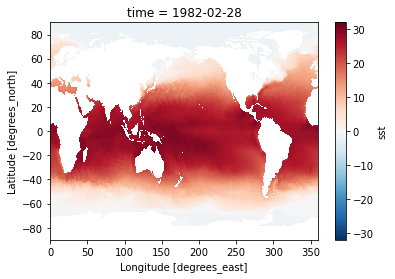

In [5]:
# Plot SST
oisst_months.sst.isel(time = 5).plot()

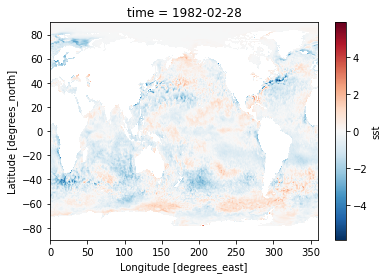

In [6]:
# Plot anomalies
anom_months.sst.isel(time = 5).plot()

In [7]:
# Combine to same Dataset
month_tidy = xr.merge([oisst_months, anom_months.rename({"sst": "sst_anom"})])


# Set Attributes: TBD
month_tidy.attrs = {
    "Conventions"   : "CF-1.5",
    "title"         : "NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surface Temperature (OISST) Analysis, Version 2.1",
    "institution"   : "NOAA/National Centers for Environmental Information",
    "source"        : "NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/",
    "References"    : "https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html",
    "dataset_title" : "NOAA Daily Optimum Interpolation Sea Surface Temperature, Monthly Averages",
    "version"       : "Version 2.1",
    "comment"       : "Reynolds, et al.(2007) Daily High-Resolution-Blended Analyses for Sea Surface Temperature (available at https://doi.org/10.1175/2007JCLI1824.1). Banzon, et al.(2016) A long-term record of blended satellite and in situ sea-surface temperature for climate monitoring, modeling and environmental studies (available at https://doi.org/10.5194/essd-8-165-2016). Huang et al. (2020) Improvements of the Daily Optimum Interpolation Sea Surface Temperature (DOISST) Version v02r01, submitted.Climatology is based on 1971-2000 OI.v2 SST. Satellite data: Pathfinder AVHRR SST and Navy AVHRR SST. Ice data: NCEP Ice and GSFC Ice. Data less than 15 days old may be subject to revision."
    
  }
    
# Time attrs
month_tidy.time.attrs =  {
    'long_name' : 'Month',
    'delta_t'   : '0000-01-00 00:00:00',
    'avg_period': '0000-01-00 00:00:00',
    'axis'      : 'T'
}


# Last check:
month_tidy

<xarray.Dataset>
Dimensions:   (time: 508, lat: 720, lon: 1440)
Coordinates:
  * time      (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2023-12-31
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst       (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anom  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature,...
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [9]:
# Save out monthly netcdf
out_path = f'{box_root}RES_Data/OISST/oisst_mainstays/monthly_averages/oisst_monthly_1991to2020clim.nc'
month_tidy.to_netcdf(out_path)
print("Saving Monthly Averages")

Saving Monthly Averages
